# Model Output Data Visualization

### Read Me

This notebook vizualizes model outputs for supervised neural methods from the rPPG Toolbox. To use this notebook follow the following steps:

* STEP 1: Specify the `TEST.OUTPUT_SAVE_DIR` field in the `.yaml` config file of a neural method experiment.
* STEP 2: Run the neural method experiment. A `.pickle` file containing the test-data predictions and labels will be created in `TEST.OUTPUT_SAVE_DIR`.
* STEP 3: Add the path to the `pickle` file in the `TODO: Variable to Set` section as `data_out_path`.
* STEP 4: Add values for `trial_idx` (a value between 0 and the `Num Trials` print in the previous cell), `chunk_size` (number of samples to plot out), `chunk_num` (the chunk of size `chunk_size` in the signal). We suggest using the defaults at first.
* STEP 5: Run all cells. The predicted output, plotted against the ground truth ppg waveform, will be plotted in the final cell

### Imports

In [40]:
# !pip install natsort opencv-python 
# !pip install scipy
# !pip install natsort
# !pip install ipywidgets

import pathlib as pathlib
import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import re

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

def find_git_root(path=None):
    """Find the root of the git repository by searching for .git."""
    if path is None:
        path = pathlib.Path.cwd()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    raise FileNotFoundError("No .git directory found in any parent directories.")
# "\\wsl.localhost\Ubuntu-22.04\home\maciek\GitHub\rPPG-Toolbox\model_outputs\PURE_PURE_UBFC_deepphys_outputs.pickle"
# Usage:

repo_root = find_git_root()
# data_out_path = repo_root / "model_outputs/PURE_PURE_UBFC_deepphys_outputs.pickle"
data_out_path = repo_root / "runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle"

### Helper Functions

In [20]:
# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts. """
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    sort_data = torch.cat(sort_data, dim=0)

    if flatten:
        sort_data = np.reshape(sort_data.cpu(), (-1))
    else:
        sort_data = np.array(sort_data.cpu())

    return sort_data

def _process_signal(signal, fs=30, diff_flag=True):
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal


### TODO: Variables To Set

In [ ]:
# data_out_path = "./sample_output.pickle"  # Output Data Path NOT NEEDED ANYMORE
trial_idx = 0
chunk_size = 180 # size of chunk to visualize: -1 will plot the entire signal
chunk_num = 0

### Read Data, and Extract Trials List

In [41]:
if not data_out_path.exists():
    print(f"ERROR: File not found: {data_out_path}")
else:
    with open(data_out_path, 'rb') as f:
        data = pickle.load(f)
        
    # List of all video trials
    trial_list = list(data['predictions'].keys())
    print('Num Trials', len(trial_list))

Num Trials 1


In [ ]:
# data.keys()  # ['predictions', 'labels', 'video_fps', 'video_names']
# data['predictions'].keys()  # ['PURE_TSCAN_UBFC_1', 'PURE_TSCAN_UBFC_2', ...]

dict_keys(['subject1'])

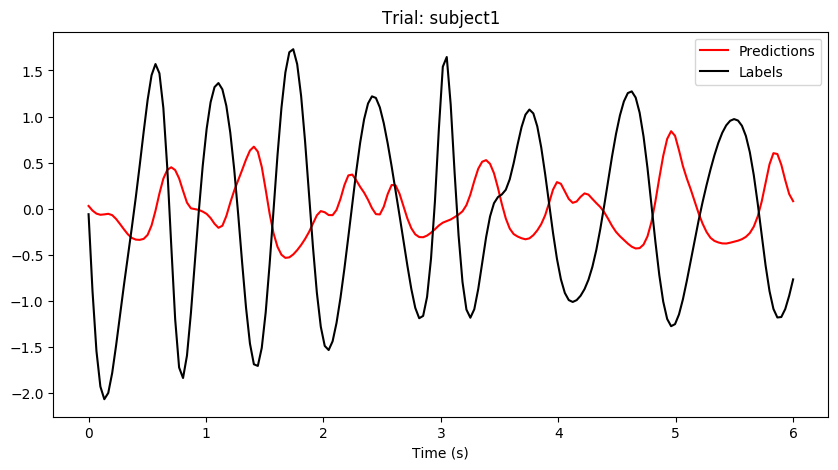

In [42]:
# Reform label and prediction vectors from multiple trial chunks
prediction = np.array(_reform_data_from_dict(data['predictions'][trial_list[trial_idx]]))
label = np.array(_reform_data_from_dict(data['labels'][trial_list[trial_idx]]))

# Read in meta-data from pickle file
fs = data['fs'] # Video Frame Rate
label_type = data['label_type'] # PPG Signal Transformation: `DiffNormalized` or `Standardized`
diff_flag = (label_type == 'DiffNormalized')

if chunk_size == -1:
    chunk_size = len(prediction)
    chunk_num = 0

# Process label and prediction signals
prediction = _process_signal(prediction, fs, diff_flag=diff_flag)
label = _process_signal(label, fs, diff_flag=diff_flag)
start = (chunk_num)*chunk_size
stop = (chunk_num+1)*chunk_size
samples = stop - start
x_time = np.linspace(0, samples/fs, num=samples)

plt.figure(figsize=(10,5))
plt.plot(x_time, prediction[start:stop], color='r')
plt.plot(x_time, label[start:stop], color='black')
plt.title('Trial: ' + trial_list[trial_idx])
plt.legend(['Predictions', 'Labels'])
plt.xlabel('Time (s)');

In [34]:
import sys
import os
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')  # Add the toolbox directory

import pickle
import numpy as np
from evaluation.post_process import calculate_metric_per_video

# Load your results
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

# Extract predictions from your results
predictions = results['predictions'] if 'predictions' in results else results
labels = results['labels'] if 'labels' in results else None

# Convert PPG signals to heart rate
heart_rates = {}

for subject_id, prediction_chunks in predictions.items():
    # Combine all chunks for this subject
    full_prediction = []
    for chunk_idx in sorted(prediction_chunks.keys()):
        chunk_data = prediction_chunks[chunk_idx]
        if hasattr(chunk_data, 'numpy'):
            chunk_data = chunk_data.numpy()
        full_prediction.extend(chunk_data.flatten())
    
    full_prediction = np.array(full_prediction)
    
    # Convert differential PPG to heart rate using FFT
    # diff_flag=True because your config uses DiffNormalized
    hr_label, hr_pred, SNR, macc = calculate_metric_per_video(
        full_prediction, 
        full_prediction,  # Using prediction as both pred and label for now
        fs=30,  # Your sampling frequency
        diff_flag=True,  # Because you're using DiffNormalized
        use_bandpass=True,
        hr_method='FFT'
    )
    
    heart_rates[subject_id] = hr_pred

print("Heart rates (BPM) for each subject:")
for subject_id, hr in heart_rates.items():
    print(f"Subject {subject_id}: {hr:.1f} BPM")

KeyboardInterrupt: 

In [32]:
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== PICKLE FILE ANALYSIS ===")
print("Type:", type(results))
print("Keys:", list(results.keys()) if isinstance(results, dict) else "Not a dict")

# If it's the standard format with predictions and labels
if 'predictions' in results:
    predictions = results['predictions']
    labels = results['labels']
    
    print(f"\nNumber of subjects in predictions: {len(predictions)}")
    print(f"Number of subjects in labels: {len(labels)}")
    
    print("\nSubjects in predictions:")
    for subject_id in predictions.keys():
        chunks = len(predictions[subject_id])
        print(f"  {subject_id}: {chunks} chunks")
    
    # Check if subject1 exists (your current run)
    if 'subject1' in predictions:
        print(f"\n=== SUBJECT1 DETAILS (Your Current Run) ===")
        subject1_chunks = predictions['subject1']
        print(f"Number of chunks: {len(subject1_chunks)}")
        print(f"Chunk indices: {sorted(subject1_chunks.keys())}")
        
        # Show data shape for first chunk
        first_chunk = subject1_chunks[sorted(subject1_chunks.keys())[0]]
        print(f"First chunk shape: {first_chunk.shape if hasattr(first_chunk, 'shape') else len(first_chunk)}")
        
else:
    print("Unexpected pickle file structure")
    print("Contents:", results)

=== PICKLE FILE ANALYSIS ===
Type: <class 'dict'>
Keys: ['predictions', 'labels', 'label_type', 'fs']

Number of subjects in predictions: 42
Number of subjects in labels: 42

Subjects in predictions:
  subject10: 11 chunks
  subject11: 11 chunks
  subject12: 11 chunks
  subject13: 11 chunks
  subject14: 11 chunks
  subject15: 11 chunks
  subject16: 11 chunks
  subject17: 11 chunks
  subject18: 11 chunks
  subject1: 8 chunks
  subject20: 11 chunks
  subject22: 11 chunks
  subject23: 10 chunks
  subject24: 11 chunks
  subject25: 8 chunks
  subject26: 8 chunks
  subject27: 7 chunks
  subject30: 11 chunks
  subject31: 11 chunks
  subject32: 11 chunks
  subject33: 11 chunks
  subject34: 11 chunks
  subject35: 11 chunks
  subject36: 11 chunks
  subject37: 11 chunks
  subject38: 11 chunks
  subject39: 11 chunks
  subject3: 10 chunks
  subject40: 11 chunks
  subject41: 11 chunks
  subject42: 11 chunks
  subject43: 11 chunks
  subject44: 11 chunks
  subject45: 11 chunks
  subject46: 11 chunks
 

In [27]:
import pickle
import numpy as np
import scipy.signal
from scipy.signal import butter

def convert_ppg_to_heart_rate(ppg_signal, fs=30, diff_flag=True):
    """Convert PPG signal to heart rate using FFT"""
    if diff_flag:
        ppg_signal = np.cumsum(ppg_signal)
    
    ppg_signal = scipy.signal.detrend(ppg_signal)
    [b, a] = butter(1, [0.6/fs*2, 3.3/fs*2], btype='bandpass')
    ppg_signal = scipy.signal.filtfilt(b, a, np.double(ppg_signal))
    
    N = 2 ** int(np.ceil(np.log2(len(ppg_signal))))
    f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    
    hr_range = (0.6, 3.3)
    valid_indices = np.where((f_ppg >= hr_range[0]) & (f_ppg <= hr_range[1]))[0]
    peak_freq = f_ppg[valid_indices[np.argmax(pxx_ppg[valid_indices])]]
    
    return peak_freq * 60

# Load results
with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

predictions = results['predictions']
fs = results['fs']  # Use the sampling rate from the file

print("=== YOUR VIDEO'S HEART RATE (SUBJECT1) ===")
subject1_data = predictions['subject1']

print(f"Available chunks: {sorted(subject1_data.keys())}")
print(f"Number of chunks: {len(subject1_data)}")

# Combine all chunks for subject1
full_signal = []
total_samples = 0

for chunk_idx in sorted(subject1_data.keys()):
    chunk_data = subject1_data[chunk_idx]
    
    # Convert tensor to numpy if needed
    if hasattr(chunk_data, 'numpy'):
        chunk_data = chunk_data.numpy()
    elif hasattr(chunk_data, 'cpu'):
        chunk_data = chunk_data.cpu().numpy()
    
    chunk_signal = chunk_data.flatten()
    full_signal.extend(chunk_signal)
    total_samples += len(chunk_signal)
    print(f"  Chunk {chunk_idx}: {len(chunk_signal)} samples")

full_signal = np.array(full_signal)

print(f"\nCombined signal:")
print(f"  Total samples: {len(full_signal)}")
print(f"  Duration: {len(full_signal)/fs:.1f} seconds")
print(f"  Sampling rate: {fs} Hz")

# Calculate overall heart rate
hr = convert_ppg_to_heart_rate(full_signal, fs=fs, diff_flag=True)
print(f"\n🫀 YOUR VIDEO'S HEART RATE: {hr:.1f} BPM")

# Calculate per-chunk heart rates for comparison
print(f"\nPer-chunk heart rates:")
chunk_hrs = []
for chunk_idx in sorted(subject1_data.keys()):
    chunk_data = subject1_data[chunk_idx]
    if hasattr(chunk_data, 'numpy'):
        chunk_data = chunk_data.numpy()
    elif hasattr(chunk_data, 'cpu'):
        chunk_data = chunk_data.cpu().numpy()
    
    chunk_signal = chunk_data.flatten()
    if len(chunk_signal) >= 90:  # Need minimum length for reliable FFT (3 seconds)
        chunk_hr = convert_ppg_to_heart_rate(chunk_signal, fs=fs, diff_flag=True)
        chunk_hrs.append(chunk_hr)
        print(f"  Chunk {chunk_idx}: {chunk_hr:.1f} BPM")
    else:
        print(f"  Chunk {chunk_idx}: Too short for reliable HR calculation")

if chunk_hrs:
    print(f"\nHeart rate statistics:")
    print(f"  Mean: {np.mean(chunk_hrs):.1f} BPM")
    print(f"  Std:  {np.std(chunk_hrs):.1f} BPM")
    print(f"  Min:  {np.min(chunk_hrs):.1f} BPM")
    print(f"  Max:  {np.max(chunk_hrs):.1f} BPM")

=== YOUR VIDEO'S HEART RATE (SUBJECT1) ===
Available chunks: [0, 1, 2, 3, 4, 5, 6, 7]
Number of chunks: 8
  Chunk 0: 180 samples
  Chunk 1: 180 samples
  Chunk 2: 180 samples
  Chunk 3: 180 samples
  Chunk 4: 180 samples
  Chunk 5: 180 samples
  Chunk 6: 180 samples
  Chunk 7: 180 samples

Combined signal:
  Total samples: 1440
  Duration: 48.0 seconds
  Sampling rate: 30 Hz

🫀 YOUR VIDEO'S HEART RATE: 109.9 BPM

Per-chunk heart rates:
  Chunk 0: 70.3 BPM
  Chunk 1: 105.5 BPM
  Chunk 2: 105.5 BPM
  Chunk 3: 112.5 BPM
  Chunk 4: 105.5 BPM
  Chunk 5: 112.5 BPM
  Chunk 6: 112.5 BPM
  Chunk 7: 105.5 BPM

Heart rate statistics:
  Mean: 103.7 BPM
  Std:  13.0 BPM
  Min:  70.3 BPM
  Max:  112.5 BPM


In [37]:
import pickle
import numpy as np
import sys
import os

# Add the rPPG-Toolbox path to Python path
sys.path.append('/home/maciek/GitHub/rPPG-Toolbox')

# Import the correct evaluation function
from evaluation.post_process import calculate_metric_per_video

# Load your results
# runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle
data_out_path = 'runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle'

with open(data_out_path, 'rb') as f:
    results = pickle.load(f)

print("=== YOUR HEART RATE RESULTS ===")
print(f"Sampling frequency: {results['fs']} Hz")
print(f"Label type: {results['label_type']}")

# Extract predictions and labels for your subject
predictions = results['predictions']['subject1']  # Your subject
labels = results['labels']['subject1'] if 'subject1' in results['labels'] else None

print(f"\nNumber of video chunks: {len(predictions)}")

# Calculate heart rate for each chunk using the toolbox's own function
chunk_hrs = []
chunk_hr_labels = []

for i, pred_chunk in enumerate(predictions):
    # Convert to numpy if it's a tensor
    if hasattr(pred_chunk, 'numpy'):
        pred_chunk = pred_chunk.numpy().flatten()
    else:
        pred_chunk = pred_chunk.flatten()
    
    # Get corresponding label if available
    if labels and i < len(labels):
        label_chunk = labels[i]
        if hasattr(label_chunk, 'numpy'):
            label_chunk = label_chunk.numpy().flatten()
        else:
            label_chunk = label_chunk.flatten()
        
        # Use the toolbox's function to calculate HR
        hr_label, hr_pred, snr, macc = calculate_metric_per_video(
            pred_chunk, label_chunk, 
            fs=results['fs'], 
            diff_flag=True,  # Your data type suggests differential signals
            use_bandpass=True, 
            hr_method='FFT'
        )
        
        chunk_hrs.append(hr_pred)
        chunk_hr_labels.append(hr_label)
        print(f"Chunk {i}: Predicted = {hr_pred:.1f} BPM, Ground Truth = {hr_label:.1f} BPM, Error = {abs(hr_pred-hr_label):.1f} BPM")
    
    else:
        # No ground truth available, calculate prediction only
        # Manual FFT calculation (similar to toolbox function)
        from evaluation.post_process import _calculate_fft_hr, _detrend
        
        # Detrend and process the signal
        processed_pred = _detrend(np.cumsum(pred_chunk), 100)  # Integrate differential signal
        hr_pred = _calculate_fft_hr(processed_pred, fs=results['fs'])
        
        chunk_hrs.append(hr_pred)
        print(f"Chunk {i}: Predicted = {hr_pred:.1f} BPM (no ground truth)")

if chunk_hrs:
    mean_hr = np.mean(chunk_hrs)
    std_hr = np.std(chunk_hrs)
    print(f"\n=== SUMMARY ===")
    print(f"Average Predicted Heart Rate: {mean_hr:.1f} ± {std_hr:.1f} BPM")
    print(f"Range: {min(chunk_hrs):.1f} - {max(chunk_hrs):.1f} BPM")
    
    if chunk_hr_labels:
        mean_hr_label = np.mean(chunk_hr_labels)
        overall_mae = np.mean([abs(p-l) for p,l in zip(chunk_hrs, chunk_hr_labels)])
        print(f"Average Ground Truth Heart Rate: {mean_hr_label:.1f} BPM")
        print(f"Overall MAE: {overall_mae:.1f} BPM")

FileNotFoundError: [Errno 2] No such file or directory: 'runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle'